In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1986 오차역전파

In [3]:
class 곱하기:
    def __init__(self):
        self.x = None
        self.y = None

    def __call__(self, x, y):
        self.x = x
        self.y = y
        return x * y
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        return dx, dy

In [6]:
단가, 수량, 부가세 = 100, 2, 1.1
곱1 = 곱하기()
곱2 = 곱하기()

세전가격 = 곱1(단가, 수량)
세후가격 = 곱2(세전가격, 부가세)
print(f'{단가} * {수량} = {세전가격}')
print(f'{세전가격} * {부가세} = {세후가격:.0f}')

# 역전파
print('역전파')
d세전가격, d부가세 = 곱2.backward(1)
d단가, d수량 = 곱1.backward(d세전가격)
print(f'd단가 = {d단가:.1f}, d수량 = {d수량:.1f}, d부가세 = {d부가세:.1f}')

100 * 2 = 200
200 * 1.1 = 220
역전파
d단가 = 2.2, d수량 = 110.0, d부가세 = 200.0


# 역전파 신경망 구현

In [7]:
import numpy as np

class Sigmoid:
    def __init__(self):
        self.y = None

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        y = 1 / (1 + np.exp(-x))
        self.y = y
        return y

    def backward(self, dout):
        dx = dout * self.y * (1 - self.y)
        return dx

class 완전연결:
    def __init__(self, 입력수, 출력수, 활성화=None):
        self.W = np.random.randn(입력수, 출력수)
        self.b = np.zeros(출력수)
        self.activation = 활성화
        self.x = None
        self.dW = None
        self.db = None

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        self.x = x
        z = np.dot(x, self.W) + self.b
        if self.activation:
            return self.activation(z)
        return z

    def backward(self, dout):
        if self.activation:
            dout = self.activation.backward(dout)
            
        self.dW = np.dot(self.x.T, dout)
        # 배치 단위 연산 시, 미분값을 모든 표본에 대해 더합니다.
        self.db = np.sum(dout, axis=0)
        
        dx = np.dot(dout, self.W.T)
        return dx

def softmax(z):
    if z.ndim == 1:
        z = z.reshape(1, -1)
    exp_z = np.exp(z - np.max(z, axis=1).reshape(-1, 1))
    return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)

def 교차엔트로피오차(y, y_pred):
    delta = 1e-7
    배치크기 = y.shape[0]
    return -np.sum(y * np.log(y_pred + delta)) / 배치크기

class CrossEntropy:
    def __init__(self, from_logits=False):
        self.y = None
        self.from_logits = from_logits
        self.proba = None

    def __call__(self, z, y):
        return self.forward(z, y)

    def forward(self, outputs, y):
        self.y = y
        # z -> softmax -> proba
        if self.from_logits:            
            self.proba = outputs
        else:
            self.proba = softmax(outputs)
        # CEE(y, proba)
        손실 = 교차엔트로피오차(y, self.proba)
        return 손실

    def backward(self, dout=1):
        배치크기 = len(self.y)
        dz = self.proba - self.y
        return dz / 배치크기

class 역전파신경망:
    def __init__(self, 손실함수):
        self.layers = []
        self.loss_func = 손실함수

    def add(self, layer):
        self.layers.append(layer)

    def __call__(self, x):
        """순전파"""
        outputs = x
        for layer in self.layers:
            outputs = layer(outputs)
        return outputs # z_last

    def 손실산출(self, x, y):
        outputs = self(x)
        손실 = self.loss_func(outputs, y)
        return 손실

    def fit(self, x, y, 배치크기, 에폭수, 학습률):
        에폭당_배치수 = len(x) // 배치크기
        학습횟수 = 에폭당_배치수 * 에폭수
        print(f'배치크기={배치크기}, 에폭수={에폭수}, 학습횟수={학습횟수}({에폭당_배치수}/에폭)')
        손실변화 = []
        for 학습 in range(학습횟수):
            # 1. 미니 배치
            표본수 = S = len(x)
            배치색인 = np.random.choice(표본수, 배치크기)
            x_batch = x[배치색인]
            y_batch = y[배치색인]
            # 2. 경사 산출 (역전파)
            # 1) 순전파
            손실 = self.손실산출(x_batch, y_batch)
            손실변화.append(손실)
            # 2) 역전파            
            dout = self.loss_func.backward(1)
            for layer in reversed(self.layers):
                dout = layer.backward(dout)
            # 3. 매개변수 갱신 (경사 하강)
            for layer in self.layers:
                if isinstance(layer, 완전연결):
                    layer.W -= layer.dW * 학습률
                    layer.b -= layer.db * 학습률

            if 학습 == 0 or (학습 + 1) % 100 == 0:
                print(f'[학습 {학습 + 1}] Loss: {손실:.3f}')
        return 손실변화


In [8]:
model = 역전파신경망(손실함수=CrossEntropy(from_logits=True))
model.add(완전연결(입력수=784, 출력수=50, 활성화=Sigmoid()))
model.add(완전연결(입력수=50, 출력수=100, 활성화=Sigmoid()))
model.add(완전연결(입력수=100, 출력수=10))

In [9]:
import pickle

with open('data/mnist/mnist_ndarray.pkl', 'rb') as 파일:
    mnist = pickle.load(파일)

(train_images, train_labels), (test_images, test_labels) = mnist

assert (28, 28) == train_images.shape[1:] == test_images.shape[1:]
assert set(np.unique(train_labels)) == set(range(10))
assert len(train_images) == len(train_labels)
assert len(test_images) == len(test_labels)

In [10]:
def 전처리(이미지들, 목표형상):
    X = 이미지들.reshape(-1, *목표형상)
    X = X / 255
    return X.astype(np.float32)

목표형상 = (784, )
X_train = 전처리(train_images, 목표형상)
X_test = 전처리(test_images, 목표형상)

assert 목표형상 == X_train.shape[1:] == X_test.shape[1:]    
assert np.allclose(1.0, X_train.max()) and np.allclose(0.0, X_train.min())
assert np.allclose(1.0, X_test.max()) and np.allclose(0.0, X_test.min())

In [47]:
model = 역전파신경망(손실함수=CrossEntropy(from_logits=False))
model.add(완전연결(입력수=784, 출력수=50, 활성화=Sigmoid()))
model.add(완전연결(입력수=50, 출력수=100, 활성화=Sigmoid()))
model.add(완전연결(입력수=100, 출력수=10))

원핫행렬 = np.eye(10)
y_train = 원핫행렬[train_labels]
손실변화 = model.fit(X_train, y_train, 배치크기=60000, 에폭수=10, 학습률=0.1)


배치크기=60000, 에폭수=10, 학습횟수=10(1/에폭)
[학습 1] Loss: 11.996


In [48]:
outputs = model(X_test)
y_pred = outputs.argmax(axis=1)
accuracy = (y_pred == test_labels).mean()
print(f"정확도: {accuracy:.2%}")

정확도: 13.56%


In [34]:
samples = np.arange(100)
배치크기 = 10
np.random.choice(samples, 배치크기)

array([29,  1, 42, 73, 77, 80, 60, 63, 72,  0])

[5.676771219220018, 5.305398503672416, 4.9865455053807315, 4.720600636442591, 4.458802636574539]


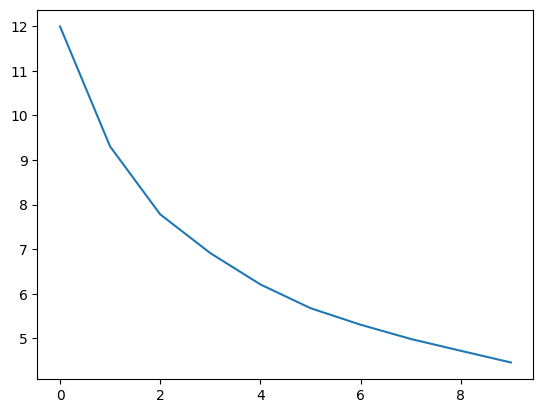

In [49]:
print(손실변화[-5:])
plt.plot(손실변화)
plt.show()

# 딥러닝 프레임워크

1. Tensorflow(2015)
2. Pytorch(2017)

In [52]:
import tensorflow as tf
print(tf.__version__)


2.16.1


In [64]:
from tensorflow import keras
from tensorflow.keras import layers

def 모델공장(show_summary=False):
    model = keras.Sequential()
    model.add(layers.Dense(50, activation='sigmoid', input_shape=(784,), name='FC1'))
    model.add(layers.Dense(100, activation='sigmoid', name='FC2'))
    model.add(layers.Dense(10, activation='softmax', name='prediction'))
    if show_summary:
        model.summary()
    return model

model = 모델공장(show_summary=True)

/opt/homebrew/Caskroom/miniconda/base/envs/pydeep/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ FC1 (Dense)                     │ (None, 50)             │        39,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC2 (Dense)                     │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,360 (177.19 KB)

 Trainable params: 45,360 (177.19 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
# 연산 장치 지어: 기본 GPU
with tf.device('cpu'):
    model = 모델공장()
    # 학습 설정: 손실함수, 최적화 방법 등
    model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.SGD(learning_rate=0.1),
    )
    # 학습
    result = model.fit(X_train, y_train, batch_size=100, epochs=20)

Epoch 1/20
121/600 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 2.3070

/opt/homebrew/Caskroom/miniconda/base/envs/pydeep/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 2.1271
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 0.8441
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 0.4901
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 0.3844
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 0.3347
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 0.3012
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 0.2802
Epoch 8/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 0.2572
Epoch 9/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 0.2419
Epoch 10/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 0.2282
Epoch 11/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 0.2182
Epoch 12/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 0.2039
Epoch 13/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 0.1935
Epoch 14/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 0.1811
Epoch 15/20
600/600 ━━━━━━━━━━━━━━━━━━━━

In [82]:
outputs = model(X_test)
y_pred = np.argmax(outputs, axis=1)
accuracy = (y_pred == test_labels).mean()
print(f"정확도: {accuracy:.2%}")

정확도: 95.70%


In [90]:
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

print(train_images.shape, test_images.shape)
assert (28, 28) == train_images.shape[1:] == test_images.shape[1:]
assert set(np.unique(train_labels)) == set(range(10))
assert len(train_images) == len(train_labels)
assert len(test_images) == len(test_labels)

(60000, 28, 28) (10000, 28, 28)


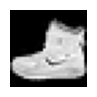

In [85]:
image = train_images[0]
plt.figure(figsize=(1, 1))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

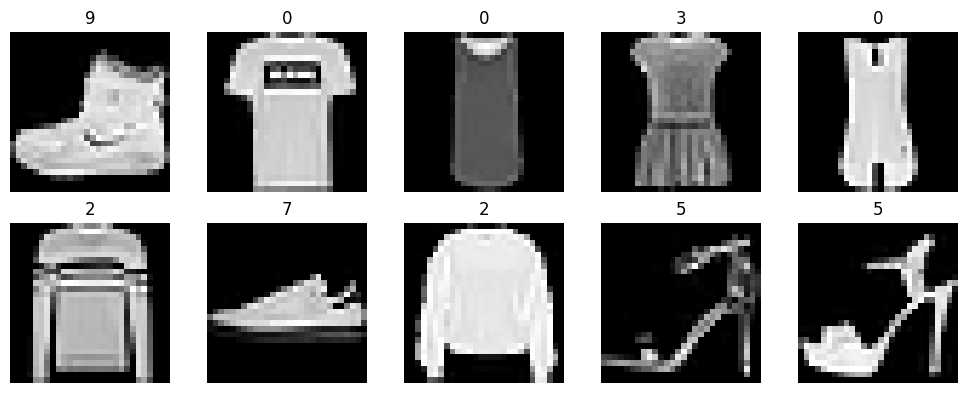

In [94]:
# 10개 이미지 출력
그림들, 그래프들 = plt.subplots(2, 5, figsize=(10, 4))
for 영역, 이미지, 라벨 in zip(그래프들.flat, train_images, train_labels):
    영역.imshow(이미지, cmap='gray')
    영역.axis('off')
    영역.set_title(라벨)

plt.tight_layout()
plt.show()

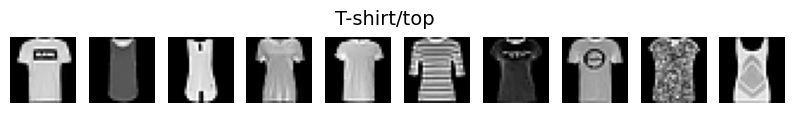

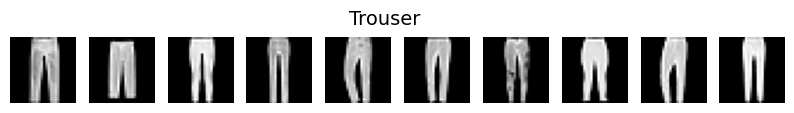

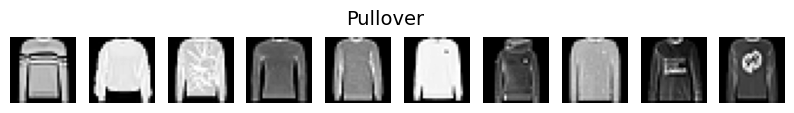

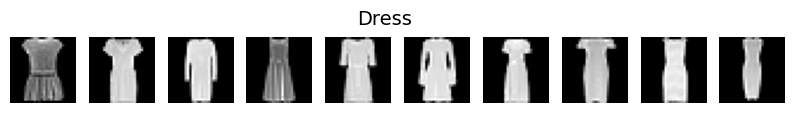

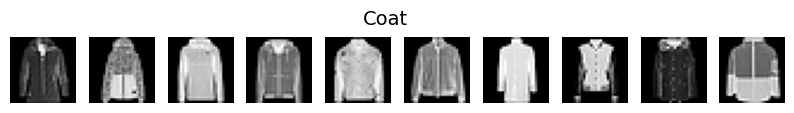

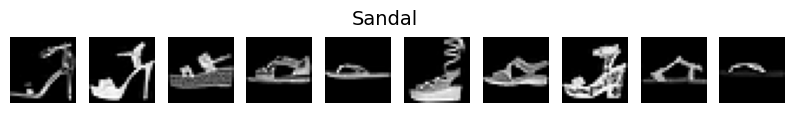

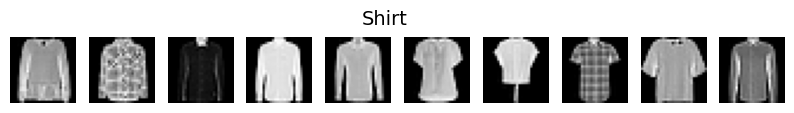

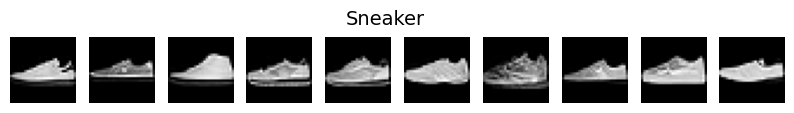

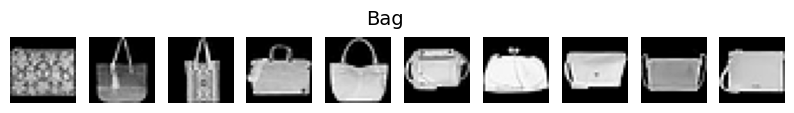

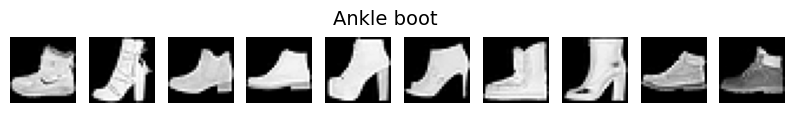

In [96]:
# Fashion MNIST 데이터셋 로드
(train_images, train_labels), (_, _) = fashion_mnist.load_data()

# 각 클래스별로 10개씩의 데이터 표시
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 각 클래스별로 10개의 데이터 표시
for class_idx in range(len(classes)):
    class_indices = np.where(train_labels == class_idx)[0][:10]  # 클래스 인덱스에 해당하는 이미지 인덱스 추출
    plt.figure(figsize=(10, 1))
    for i, img_idx in enumerate(class_indices):
        plt.subplot(1, 10, i + 1)
        plt.imshow(train_images[img_idx], cmap='gray')
        plt.axis('off')
    plt.suptitle(classes[class_idx], y=1.1, fontsize=14)
    plt.show()

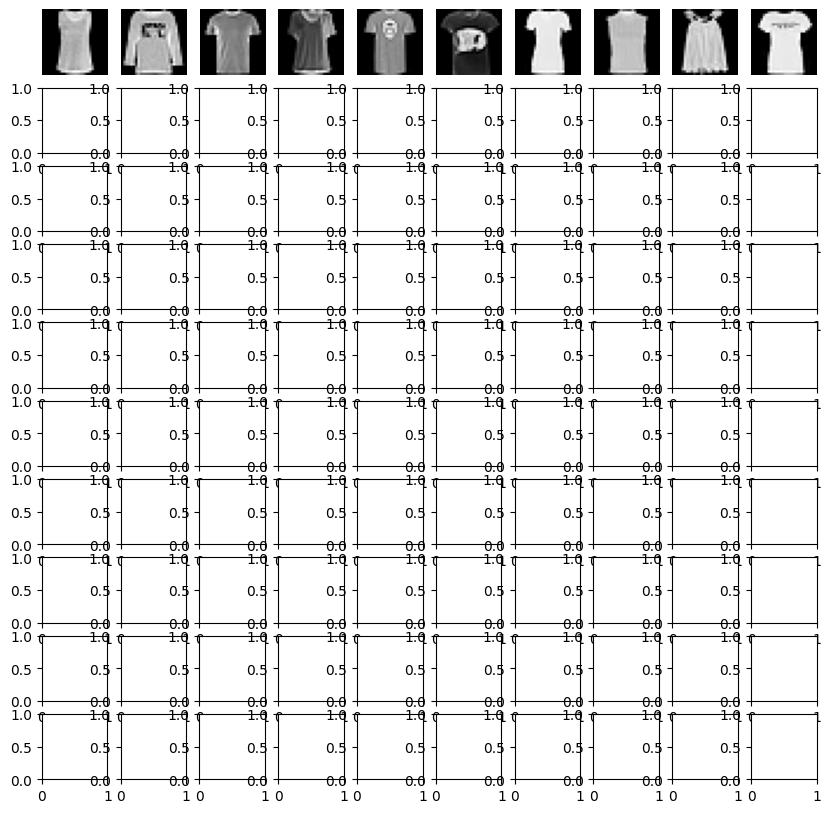

In [97]:
# 유형별 10개씩 무작위로 선택해서 10x10 출력
필터 = train_labels == 0
색인 = np.where(필터)[0]
선별 = np.random.permutation(색인)[:10]

그림들, 그래프들 = plt.subplots(10, 10, figsize=(10, 10))
for 영역, 인덱스 in zip(그래프들.flat, 선별):
    영역.imshow(train_images[인덱스], cmap='gray')
    영역.axis('off')

In [103]:
def 전처리(이미지들, 목표형상):
    X = 이미지들.reshape(-1, *목표형상)
    X = X / 255
    return X.astype(np.float32)

목표형상 = (784, )
X_train = 전처리(train_images, 목표형상)
X_test = 전처리(test_images, 목표형상)

assert 목표형상 == X_train.shape[1:] == X_test.shape[1:]    
assert np.allclose(1.0, X_train.max()) and np.allclose(0.0, X_train.min())
assert np.allclose(1.0, X_test.max()) and np.allclose(0.0, X_test.min())

In [141]:
def MLP공장(입력형상, hidden_units, show_summary=False):
    model = keras.Sequential()
    model.add(keras.Input(shape=(입력형상,)))
    # 은닉층
    for units in hidden_units:
        model.add(layers.Dense(units, activation='sigmoid'))
    
    # 출력층
    model.add(layers.Dense(10, activation='softmax'))
    if show_summary:
        model.summary()
    return model

MLP공장(입력형상=784, hidden_units=[50, 100], show_summary=True)

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 50)             │        39,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,360 (177.19 KB)

 Trainable params: 45,360 (177.19 KB)

 Non-trainable params: 0 (0.00 B)

<Sequential name=sequential_44, built=True>

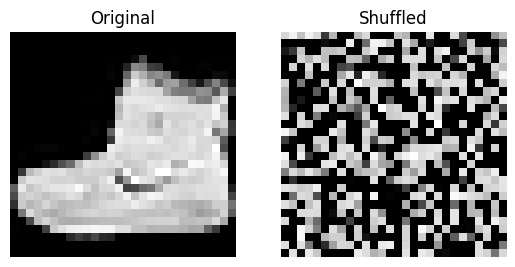

In [144]:
# 픽셀순서 무작위로 섞기
픽셀순서 = np.random.permutation(784)
XR_train = X_train[:, 픽셀순서] 
XR_test = X_test[:, 픽셀순서]

# 원래 이미지와 섞인 이미지 비교
plt.subplot(1, 2, 1)
plt.imshow(X_train[0].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(XR_train[0].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title('Shuffled')
plt.show()

In [145]:
with tf.device('cpu'):
    model = MLP공장(입력형상=784, hidden_units=[32, 64])
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),
        # optimizer=keras.optimizers.SGD(learning_rate=1.0, momentum=0.5),
        # optimizer=keras.optimizers.Adagrad(learning_rate=1.0), # 2011
        # optimizer=keras.optimizers.RMSprop(learning_rate=0.1), # 2012
        optimizer=keras.optimizers.Adam(learning_rate=0.001), # 2014
        metrics=['accuracy']
    )
    result = model.fit(XR_train, train_labels, batch_size=100, epochs=50)

Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step - accuracy: 0.5681 - loss: 1.5163
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - accuracy: 0.8086 - loss: 0.5458
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - accuracy: 0.8427 - loss: 0.4451
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.8569 - loss: 0.4017
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - accuracy: 0.8655 - loss: 0.3726
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - accuracy: 0.8702 - loss: 0.3612
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - accuracy: 0.8756 - loss: 0.3484
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.8777 - loss: 0.3398
Epoch 9/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.8817 - loss: 0.3264
Epoch 10/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.8834 - loss: 0.3214
Epoch 11/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.8849 - loss: 0.3148
Epoch 12/50
600/600 ━━━━━━━━━━

In [147]:
test_loss, test_acc = model.evaluate(XR_test, test_labels)
print(f'손실: {test_loss:.3f}, 정확도: {test_acc:.2%}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8666 - loss: 0.4688
손실: 0.443, 정확도: 86.87%


In [148]:
def 합성곱공장(입력형상, show_summary=False):
    model = keras.Sequential()
    model.add(keras.Input(shape=입력형상))
    # 은닉층
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    # 출력층
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='softmax'))
    if show_summary:
        model.summary()
    return model

합성곱공장(입력형상=(28, 28, 1), show_summary=True)


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │       216,330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,650 (846.29 KB)

 Trainable params: 216,650 (846.29 KB)

 Non-trainable params: 0 (0.00 B)

<Sequential name=sequential_48, built=True>

In [149]:
X_train = 전처리(train_images, 목표형상=(28, 28, 1))

with tf.device('cpu'):
    model = 합성곱공장(입력형상=(28, 28, 1))
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),
        # optimizer=keras.optimizers.SGD(learning_rate=1.0, momentum=0.5),
        # optimizer=keras.optimizers.Adagrad(learning_rate=1.0), # 2011
        # optimizer=keras.optimizers.RMSprop(learning_rate=0.1), # 2012
        optimizer=keras.optimizers.Adam(learning_rate=0.001), # 2014
        metrics=['accuracy']
    )
    result = model.fit(X_train, train_labels, batch_size=100, epochs=50)

Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7810 - loss: 0.6265
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8901 - loss: 0.3110
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9015 - loss: 0.2710
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9144 - loss: 0.2402
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9214 - loss: 0.2217
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9252 - loss: 0.2099
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9298 - loss: 0.1946
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9361 - loss: 0.1824
Epoch 9/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9389 - loss: 0.1753
Epoch 10/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9419 - loss: 0.1603
Epoch 11/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9450 - loss: 0.1536
Epoch 12/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step